In [1]:
import sys
import os
from datetime import datetime
import json
import shutil
import random
import ast
import numpy as np
import pandas as pd
#import tensorflow as tf
#from tensorflow import keras
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt

sys.path.append('../src/')
from env import BTCMarket_Env
from agent import Trader_Agent
from DQNtrainer import DQNTrainer
from DRLtrainer import DRLTrainer
from collections import deque
import h5py
from itertools import product


2023-03-28 17:14:34.927183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 17:14:35.080196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/arnold/systemc-2.3.3/lib-linux64
2023-03-28 17:14:35.080220: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-28 17:14:35.112117: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-28

In [2]:
hpo_params= { 
    'obs_space' : [(8,20)], 
    'action_domain' : [(0.0,1.0)], # (-1.0,1.0),
    'money' : [10000], 
    'fee' : [0.001], 
    'asset' : ['BTC', 'PERP'],
#    'reward_function' : ['compute_reward_from_tutor', 'reward_sharpe_ratio', 'reward_sortino_ratio', 
#                        'reward_differential_sharpe_ratio', 'reward_sterling_ratio'],
    'reward_function' : ['compute_reward_from_tutor'],
    
    'learning_rate': [1e-3],
    'trainer' : ['DQNTrainer'], # 'DRLTrainer', 'DQNTrainer'
    'episodes' : [1], 
    'runs_p_eps' : [1], 
    'batch_size': [100],
    'epoch': [5],
    'gamma': [0.95],
    
    'epsilon': [0.7],
    'epsilon_final':[0.01],
    'epsilon_decay':[0.995],
}


keys, values = zip(*hpo_params.items())
hpo_list = [dict(zip(keys, v)) for v in product(*values)]
print(hpo_list)

[{'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'BTC', 'reward_function': 'compute_reward_from_tutor', 'learning_rate': 0.001, 'trainer': 'DQNTrainer', 'episodes': 1, 'runs_p_eps': 1, 'batch_size': 100, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.7, 'epsilon_final': 0.01, 'epsilon_decay': 0.995}, {'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'PERP', 'reward_function': 'compute_reward_from_tutor', 'learning_rate': 0.001, 'trainer': 'DQNTrainer', 'episodes': 1, 'runs_p_eps': 1, 'batch_size': 100, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.7, 'epsilon_final': 0.01, 'epsilon_decay': 0.995}]


In [3]:
i = 0
#for i, param_combination in enumerate(hpo_list):
param_combination = hpo_list[0]
if param_combination.get('trainer') == 'DQNTrainer':
    action_space = 4
    algorithm = f'DQN_trial_{i}'
else:
    action_space = 1
    algorithm = f'DRL_trial_{i}'
    
param_combination['action_space'] = action_space
param_combination['algorithm'] = algorithm
print(param_combination)

env = BTCMarket_Env(observation_space = param_combination.get('obs_space', (8,20)),
        action_space = action_space,
        start_money = param_combination.get('money', 10000),
        trading_fee = param_combination.get('fee', (8,20)),
        asset = param_combination.get('asset', 'PERP'),
        reward_function = param_combination.get('reward_function', 'reward_differential_sharpe_ratio'),
                   )

agent = Trader_Agent(observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            epsilon = param_combination.get('epsilon', 0.7),
            epsilon_final = param_combination.get('epsilon_final', 0.01),
            epsilon_decay = param_combination.get('epsilon_decay', 0.995),
                    )

trainer_class = eval(param_combination.get('trainer', 'DRLTrainer'))
trainer = trainer_class(env, agent,
            observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            batch_size=param_combination.get('batch_size', 50),
            epoch=param_combination.get('epoch', 5),
            gamma=param_combination.get('gamma', 0.95),
            learning_rate=param_combination.get('learning_rate', 1e-3),
            algorithm=algorithm,
            lstm_path="./../notebooks/best_models/11_mar_2023/best_model_sequential_20back_10ahead.h5",
            # best_model_sequential_20back_10ahead lstm_2,
                       )

os.makedirs(trainer.train_folder,exist_ok=True)
with open(f'{trainer.train_folder}/params.json', 'w') as fp:
    json.dump(param_combination, fp)
    
trainer.rollout(n_episodes=param_combination.get('episodes', 2), 
                   run_per_episode=param_combination.get('runs_p_eps', 2))

{'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'BTC', 'reward_function': 'compute_reward_from_tutor', 'learning_rate': 0.001, 'trainer': 'DQNTrainer', 'episodes': 1, 'runs_p_eps': 1, 'batch_size': 100, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.7, 'epsilon_final': 0.01, 'epsilon_decay': 0.995, 'action_space': 4, 'algorithm': 'DQN_trial_0'}


2023-03-28 17:14:41.811435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/arnold/systemc-2.3.3/lib-linux64
2023-03-28 17:14:41.811492: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-28 17:14:41.811514: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-0OFSB15): /proc/driver/nvidia/version does not exist
2023-03-28 17:14:41.811800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 8)]      0           []                               
                                                                                                  
 lstm_inputs (Lambda)           (None, 20, 4)        0           ['input_1[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 10)           1953940     ['lstm_inputs[0][0]']            
                                                                                                  
 flatten_1 (Flatten)            (None, 10)           0           ['sequential[0][0]']             
                                                                                              

 14%|██████████▍                                                             | 97/671 [00:03<00:07, 76.73it/s]

Epoch 1/5
4/4 [==============================] - 5s 60ms/step - loss: 0.1865
Epoch 2/5
4/4 [==============================] - 0s 58ms/step - loss: 0.1256
Epoch 3/5
4/4 [==============================] - 0s 59ms/step - loss: 0.1246
Epoch 4/5
4/4 [==============================] - 0s 56ms/step - loss: 0.1177
Epoch 5/5
4/4 [==============================] - 0s 64ms/step - loss: 0.1136


 16%|███████████▏                                                           | 106/671 [00:16<03:52,  2.43it/s]

Data saved
episode 1, run (1/1) sample (100/671).Profit -130.84000000000015


 29%|████████████████████▋                                                  | 195/671 [00:18<00:13, 36.04it/s]/mnt/c/Users/romy_/Documents/arnolduni/ai_trader/notebooks/../src/DQNtrainer.py:292: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])
 30%|█████████████████████▎                                                 | 201/671 [00:19<00:16, 28.44it/s]

Data saved
episode 1, run (1/1) sample (200/671).Profit -518.6900000000005
Epoch 1/5
4/4 [==============================] - 0s 57ms/step - loss: 0.2076
Epoch 2/5
4/4 [==============================] - 0s 55ms/step - loss: 0.2075
Epoch 3/5
4/4 [==============================] - 0s 53ms/step - loss: 0.2075
Epoch 4/5
4/4 [==============================] - 0s 57ms/step - loss: 0.2072
Epoch 5/5
4/4 [==============================] - 0s 62ms/step - loss: 0.2071


 45%|███████████████████████████████▋                                       | 300/671 [00:28<00:09, 40.33it/s]/mnt/c/Users/romy_/Documents/arnolduni/ai_trader/notebooks/../src/DQNtrainer.py:292: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])


Data saved
episode 1, run (1/1) sample (300/671).Profit -917.0799999999999
Epoch 1/5
4/4 [==============================] - 0s 56ms/step - loss: 0.1939
Epoch 2/5
4/4 [==============================] - 0s 56ms/step - loss: 0.1939
Epoch 3/5
4/4 [==============================] - 0s 54ms/step - loss: 0.1938
Epoch 4/5
4/4 [==============================] - 0s 53ms/step - loss: 0.1938
Epoch 5/5
4/4 [==============================] - 0s 55ms/step - loss: 0.1937


 59%|█████████████████████████████████████████▉                             | 396/671 [00:37<00:05, 52.67it/s]/mnt/c/Users/romy_/Documents/arnolduni/ai_trader/notebooks/../src/DQNtrainer.py:292: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])
 60%|██████████████████████████████████████████▌                            | 402/671 [00:37<00:10, 25.82it/s]

Data saved
episode 1, run (1/1) sample (400/671).Profit -1119.4799999999996
Epoch 1/5
4/4 [==============================] - 0s 58ms/step - loss: 0.1817
Epoch 2/5
4/4 [==============================] - 0s 57ms/step - loss: 0.1816
Epoch 3/5
4/4 [==============================] - 0s 55ms/step - loss: 0.1816
Epoch 4/5
4/4 [==============================] - 0s 55ms/step - loss: 0.1816
Epoch 5/5
4/4 [==============================] - 0s 54ms/step - loss: 0.1815


 74%|████████████████████████████████████████████████████▌                  | 497/671 [00:46<00:04, 41.61it/s]/mnt/c/Users/romy_/Documents/arnolduni/ai_trader/notebooks/../src/DQNtrainer.py:292: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])
 75%|█████████████████████████████████████████████████████▏                 | 503/671 [00:47<00:08, 20.19it/s]

Data saved
episode 1, run (1/1) sample (500/671).Profit -1588.0699999999997
Epoch 1/5
4/4 [==============================] - 0s 58ms/step - loss: 0.1626
Epoch 2/5
4/4 [==============================] - 0s 58ms/step - loss: 0.1626
Epoch 3/5
4/4 [==============================] - 0s 55ms/step - loss: 0.1625
Epoch 4/5
4/4 [==============================] - 0s 55ms/step - loss: 0.1625
Epoch 5/5
4/4 [==============================] - 0s 56ms/step - loss: 0.1624


 89%|███████████████████████████████████████████████████████████████▎       | 598/671 [00:56<00:01, 39.28it/s]/mnt/c/Users/romy_/Documents/arnolduni/ai_trader/notebooks/../src/DQNtrainer.py:292: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])
 90%|███████████████████████████████████████████████████████████████▊       | 603/671 [00:57<00:04, 16.38it/s]

Data saved
episode 1, run (1/1) sample (600/671).Profit -1695.3199999999997
Epoch 1/5
4/4 [==============================] - 0s 60ms/step - loss: 0.1543
Epoch 2/5
4/4 [==============================] - 0s 73ms/step - loss: 0.1543
Epoch 3/5
4/4 [==============================] - 0s 59ms/step - loss: 0.1542
Epoch 4/5
4/4 [==============================] - 0s 55ms/step - loss: 0.1542
Epoch 5/5
4/4 [==============================] - 0s 57ms/step - loss: 0.1541


100%|██████████████████████████████████████████████████████████████████████▋| 668/671 [01:07<00:00,  9.91it/s]
/mnt/c/Users/romy_/Documents/arnolduni/ai_trader/notebooks/../src/DQNtrainer.py:292: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.train_log_dataframe = pd.concat([self.train_log_dataframe, tmp])


episode 1, finished run (1/1). Run Profit -1774.2600000000002 || money available: [4114.52],  wallet value: [8225.74]
episode 1/1. Profit -1774.2600000000002 || money available: [4114.52],  wallet value: [8225.74]
Data saved


In [8]:
# Plot profit
df = pd.read_csv(f'{trainer.train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

(669, 10)
66.46376037597656


In [5]:
df.head(10)

,Unnamed: 0,episode,run,action,state,reward,done,epsilon,profit,time_elapsed
0,0,1,1,[0.07168873 0.11045433 0.96264157 0.07455711],[[[0.5 0.99266798 0.5 0.5 ...,[1.],False,0.7,-9.99,0.011578
1,1,1,1,[0.41698422 0.22106661 0.11807427 0.80492204],[[[5.00000000e-01 9.92667982e-01 5.00000000e-0...,[1.5552129],False,0.7,-33.97,0.017153
2,2,1,1,[0.78328554 0.59045029 0.74831731 0.23282324],[[[5.00000000e-01 9.92667982e-01 5.00000000e-0...,[1.58056841],False,0.7,-33.97,0.021024
3,3,1,1,[0.16066657 0.27356416 0.59543504 0.48834911],[[[5.00000000e-01 9.92667982e-01 5.00000000e-0...,[1.55404288],False,0.7,-43.93,0.023967
4,4,1,1,[0.5867788 0.47917596 0.54678667 0.38851157],[[[5.00000000e-01 9.92667982e-01 5.00000000e-0...,[1.54560839],False,0.7,-56.16,1.514336
5,5,1,1,[0.82432173 0.27619122 0.90359603 0.14374898],[[[5.00000000e-01 9.92667982e-01 5.00000000e-0...,[1.54518001],False,0.7,-40.73,1.519193
6,6,1,1,[0.57816106 0.5081835 0.5354472 0.3927259 ],[[[5.00000000e-01 9.92667982e-01 5.00000000e-0...,[1.51817836],False,0.7,-96.23,1.590489
7,7,1,1,[0.82452099 0.54744005 0.60243345 0.31836504],[[[5.00000000e-01 9.92667982e-01 5.00000000e-0...,[1.51839236],False,0.7,-95.80,1.592653
8,8,1,1,[0.7700943 0.42217564 0.02806343 0.30684034],[[[5.00000000e-01 9.92667982e-01 5.00000000e-0...,[1.52239885],False,0.7,-123.92,1.594419
9,9,1,1,[0.72814054 0.03882248 0.13202024 0.22080529],[[[5.00000000e-01 9.92667982e-01 5.00000000e-0...,[1.543369],False,0.7,-96.83,1.596645


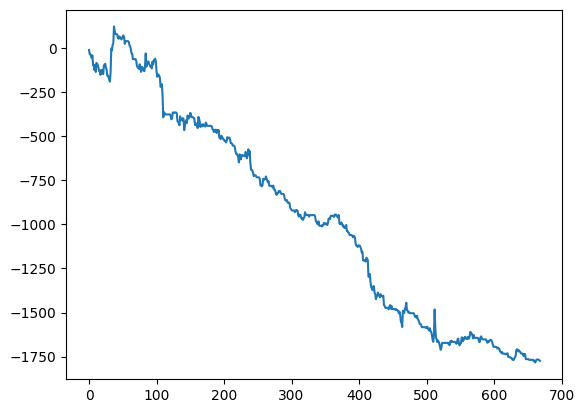

In [6]:
plt.plot(df.profit)

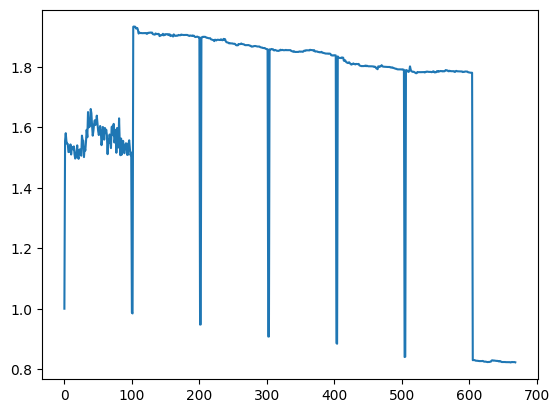

In [7]:
y = [ast.literal_eval(x)[0] for x  in df.reward]
plt.plot(y)